# MAP 554 - Lab 9 : Introduction to constrained Bayesian optimization

This lab is designed to introduce Bayesian Optimization (BO)

This Lab uses the Python library `GPy` as well as previous Labs and extends it to BO

Here we adapt the EGO algorithm to handle constraints with using EI x PF method

In [2]:
# Support for maths
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
from matplotlib import cm
from IPython.display import HTML, display

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#Gaussian process library
#!pip install GPy
import GPy

# Install PyDoE package for design of experiment
#!pip install pyDOE2
from pyDOE2 import lhs

from scipy.stats import norm
import scipy
import time
import copy


We use here the package `GPy`. The documentation for `GPy` is available at [gpy.readthedocs.io](http://gpy.readthedocs.io/en/deploy/).

A lot of packages that derive Gaussian Processes can be found in python, such as [scikit-learn](https://scikit-learn.org/stable/), [openTURNS](http://www.openturns.org/), [GPflow](https://github.com/GPflow/GPflow), [SMT](https://github.com/SMTorg/smt=), [GPyTorch](https://gpytorch.ai/), etc.

## 2. Definition of the constrained EGO algorithm

### 2.1 Global Loop

In [3]:
# The EGO algorithm takes as arguments :
# f_obj :the objective function,
# bounds : the bounds on the design variable
# k_obj_ref, k_cons_ref : kernel on objective function and list of kernels on constraints functions
# constraints : list of constraints functions
# DoE : normalized DoE (on [0,1]x R^d)
# acquisition_function : acquisition function
# num_iter : the maximal number of iterations
# threshold_EI : the threshold criterion on EI

# The EGO returns :
# List of evaluated points 
# List of new points along the iterations

def EGO(f_obj,bounds,\
        k_obj_ref,\
        k_cons_ref,\
        DoE,\
        acquisition_function,\
        constraints = None,\
        num_iter = 50,\
        threshold_EI=1e-6):
    
    current_DoE =DoE
    current_obj_non_norm = f_obj(current_DoE*(bounds[:,1]-bounds[:,0])+bounds[:,0])
    
    mean_obj = current_obj_non_norm.mean()
    std_obj = current_obj_non_norm.std()
    current_obj = (current_obj_non_norm-mean_obj)/std_obj
    current_min = np.min(current_obj)
    # Evaluation of constraints and definition of feasible points
    if constraints != None:
        current_cons = []
        x_feasible= []
        y_feasible = []
        for i in range(len(constraints)):
            current_cons.append(constraints[i](DoE*(bounds[:,1]-bounds[:,0])+bounds[:,0]))
        
        current_cons = np.array(current_cons)
        for i in range(len(DoE)):
            if len(constraints)==1:
                if current_cons[:,i]<0:
                    x_feasible.append(DoE[i])
                    y_feasible.append(current_obj[i])
                    current_min = np.min(y_feasible)
            else:
                if np.max(current_cons[:,i],axis = 0)<0:
                    x_feasible.append(DoE[i])
                    y_feasible.append(current_obj[i])
                    current_min = np.min(y_feasible)
        if len(x_feasible)==0:
            current_min = np.max(current_obj)

    ###Print of results
    print("iteration|         current |        best |   infill x PF | max g | elapsed time")
    print("------------------------------------------------------------------------------------------")
    iter_ = 0
    EI_ = 50
    t0 = time.time()
    best = []
    while iter_ < num_iter and EI_ > threshold_EI:#for i in range():
    
        #training of the models
        if constraints == None:
            #definition of GP model
            k =copy.deepcopy(k_obj_ref)
            m_obj = GPy.models.GPRegression(current_DoE,current_obj,k)
            m_obj.likelihood.variance = 1e-10
            m_obj.likelihood.variance.fix()
            m_obj.optimize()
            
            x_new,EI = optim_infill(m_obj,bounds,current_min,acquisition_function, seed = 0)
        else:
            k = copy.deepcopy(k_obj_ref)
            m_obj = GPy.models.GPRegression(current_DoE,current_obj,k)
            m_obj.likelihood.variance = 1e-10
            m_obj.likelihood.variance.fix()
            m_obj.optimize()
            
            gp_cons = []
            iter_cons = 0
            k_cons =copy.deepcopy(k_cons_ref)
            for cons in constraints:
                gp_cons.append(GPy.models.GPRegression(current_DoE,current_cons[iter_cons],k_cons[iter_cons]))
                gp_cons[-1].likelihood.variance = 1e-10
                gp_cons[-1].likelihood.variance.fix()
                gp_cons[-1].optimize()
                iter_cons +=1
            x_new,EIxPF,EI_ = optim_infill(m_obj,gp_cons,bounds,current_min,acquisition_function,seed=0)
        
        #Adding new point to the dataset
        y_new = f_obj(np.array([x_new])*(bounds[:,1]-bounds[:,0])+bounds[:,0])
        
        current_DoE = np.append(current_DoE,np.array([x_new]),axis = 0)
        current_obj = np.append(current_obj,(y_new-mean_obj)/std_obj,axis = 0)
        
        if constraints != None:
            new_cons = []
            
            for i in range(len(constraints)):
                new_cons.append(constraints[i](np.array([x_new])*(bounds[:,1]-bounds[:,0])+bounds[:,0]))
    
            current_cons =  np.concatenate((current_cons,np.array(new_cons)),axis = 1)
               
        # Calculation of new current min if feasible constraints
        if np.max(new_cons)<0:
            y_feasible.append((y_new-mean_obj)/std_obj)
            current_min = np.min(y_feasible)
        print("%9.d|%17.4e|%13.04f|%13.04f|%6.04f|%6.04f" %(iter_, y_new, std_obj*current_min+mean_obj,EIxPF,np.max(new_cons),time.time()-t0))    
        best.append(std_obj*current_min+mean_obj)
        iter_ +=1
        
    return current_DoE*(bounds[:,1]-bounds[:,0])+bounds[:,0],std_obj*current_obj+mean_obj,best

### 2.2 Acquisition function

In [4]:
#Definition of acquisition function

#Here we implement EI x PF which calls EI and PF functions
# This function requires as arguments: 
# - the point to evaluate
# - the surrogate model of objective function
# - the list of surrogate models of constraints functions
# - the current minimum


# Calculation of Probability of feasibility on a set of constraint models (gps)
def PF(x,gps):
    PF = 1.
    for gp in gps:
        pred,var = gp.predict(np.array([x]))    
        var = np.max([1e-15,var])
        std = np.sqrt(var)
        PF = PF* norm.cdf(-pred/std)     
    return PF[0][0]


# Calculation of Expected Improvement 
def EI(x,gp,y_min):
    pred,var = gp.predict(np.array([x]))
    var = np.max([1e-15,var])
    std = np.sqrt(var)
    EI = (y_min-pred)* norm.cdf((y_min-pred)/std)+std*norm.pdf((y_min-pred)/std)
    return -EI[0][0]


#Calculation of composite EIxPF infill criterion
def EIxPF(x,m_obj,m_cons,y_min):
    return  EI(x,m_obj,y_min) * PF(x,m_cons)

### 2.3 Optimization process to optimize infill criterion

In [5]:
# This function is used to optimize the infill criterion, it takes as arguments :
# m_obj : the GP of the objective function
# y_min : the current minimum
# seed : the seed of the stochastic optimization algorithm

# It returns the location of the best point to infill as well as the optimized value of EI

# Here, the Differential Evolution (See Lecture 1) is used as the EI present a lot of local minima

def optim_infill(m_obj,m_cons,bounds,y_min,acquisition_function,seed):
    f = lambda x : acquisition_function(x,m_obj,m_cons,y_min)
    bounds_norm = np.zeros((2,len(bounds)))
    if len(bounds)>1:
        bounds_norm[:,0] = 0.
        bounds_norm[:,1] = 1.
    else:
        bounds_norm = [[0.,1.]]
    np.random.seed(seed)
    struct_res = scipy.optimize.differential_evolution(f,\
                                                    popsize=50,
                                                    maxiter =100,
                                                    bounds = bounds_norm)

    x_opt = struct_res.x
    res = struct_res.fun
    EI_ = -EI(x_opt,m_obj,y_min)
    return x_opt,np.abs(res),EI_

## 3. Example on 1 - D function

Here we test the EGO algorithm on the Forrester function defined  on $[0,1]$ as follows : 
 $$ f(z) = (6z-2)^2 \sin(12z-4)$$
 
We also add a constraint on the problem defined as follows (shifted Forrester function):
$$ g(z) = (6(z+0.2)-2)^2 \sin(12(z+0.2)-4)$$

In [6]:
# definition of Forrester function
def forrester(z):    
    return (6*z-2)**2*np.sin(12*z-4)

# definition of constraint function
def cons(z):
    return (6*(z+0.2)-2)**2*np.sin(12*(z+0.2)-4)

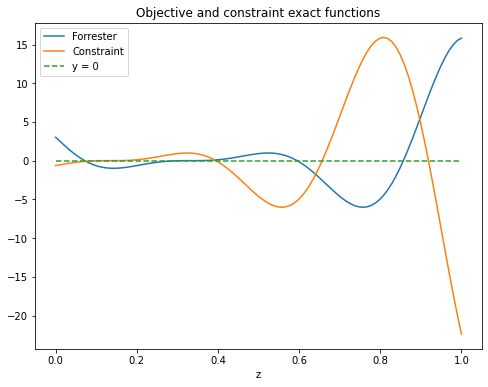

In [7]:
#Visualization of Forrester function : 
# Our sample space: 100 samples in the interval [0,1]
z0 = np.linspace(0.,1.,100)[:, None]
y = forrester(z0)
g = cons(z0)
plt.figure(figsize=(8,6))
plt.title("Objective and constraint exact functions")
plt.plot(z0,y,label = 'Forrester')
plt.plot(z0,g, label='Constraint')
plt.plot(z0,np.zeros(len(z0)),'--',label = 'y = 0')
plt.legend()
plt.xlabel("z")
display(HTML("""<style>#output-body {display: flex; align-items: center;justify-content: center;}</style>"""))  #to plot at the center of the page

Here, we will use a constrained EGO algorithm to find the global optimum

In [8]:
# Definition of initial DoE
# To generate initial DoE, we use the function 'LHS' of the package pyDOE
# The first argument is the dimension of the design vector, the second is the number of points in the DoE
z_init = lhs(1,4)
bounds = np.array([[0.,1.]])

In [9]:
# Definition of kernel
k_obj_ref = GPy.kern.RBF(1,ARD = True) 
k_cons_ref = [GPy.kern.RBF(1,ARD = True)]


In [10]:
#Run of EGO
# Here we add additional arguments : 
# - list of kernels for the constraints (k_cons_ref)
# - list of constraints calculation function (constraints)

EGO_forrester_x,EGO_forrester_y,best_forrester = EGO(forrester,bounds,\
        k_obj_ref,\
        k_cons_ref,\
        z_init,\
        EIxPF,\
        constraints = [cons],\
        num_iter = 20,\
        threshold_EI=1e-6)

iteration|         current |        best |   infill x PF | max g | elapsed time
------------------------------------------------------------------------------------------
        0|      -4.0492e-01|       0.7421|       0.0551|0.2714|0.4150
        1|      -7.7168e-01|       0.7421|       0.1681|0.0570|0.8533
        2|      -9.4434e-01|       0.7421|       0.5715|0.0081|1.3413
        3|      -6.0094e-01|      -0.6009|       0.2734|-0.0204|1.8360
        4|      -8.5027e-01|      -0.8503|       0.0904|-0.0028|2.5683
        5|      -9.3333e-01|      -0.9333|       0.0305|-0.0003|3.4406
        6|      -4.9642e+00|      -0.9333|       0.0045|6.9405|3.9643
        7|      -1.7288e+00|      -1.7288|       0.4550|-1.8807|4.7404
        8|      -2.5046e+00|      -2.5046|       0.2964|-0.1005|5.6114
        9|      -2.5462e+00|      -2.5462|       0.0158|-0.0004|7.5640
       10|       1.5830e+01|      -2.5462|       0.0000|-22.3844|9.0088


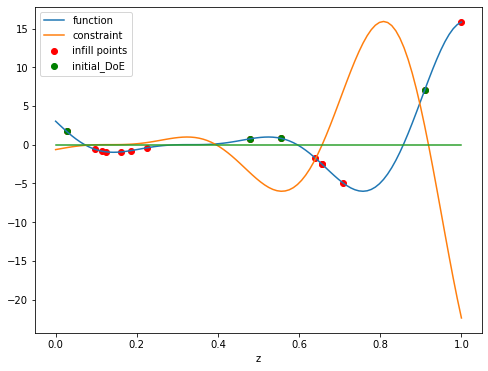

In [11]:
# Visualization of results
plt.figure(figsize=(8,6))
plt.plot(z0,y, label = 'function')
plt.plot(z0,g,label = 'constraint')
plt.scatter(EGO_forrester_x,EGO_forrester_y,c='r',label = 'infill points')
plt.scatter(z_init,forrester(z_init),c='g',label='initial_DoE')
plt.plot(z0,np.zeros(len(z0)))
plt.legend()
plt.xlabel("z")
display(HTML("""<style>#output-body {display: flex; align-items: center;justify-content: center;}</style>"""))  #to plot at the center of the page



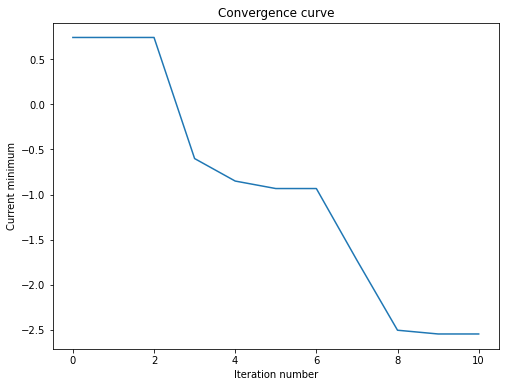

In [12]:
plt.figure(figsize=(8,6))
plt.plot(best_forrester)
plt.xlabel('Iteration number')
plt.ylabel('Current minimum')
plt.title('Convergence curve')
display(HTML("""<style>#output-body {display: flex; align-items: center;justify-content: center;}</style>"""))  #to plot at the center of the page

## 4. Example on 2 - D function

Let consider the Six Hump Camel function (Lab 8) and test constrained EGO.

Six Hump Camel function is defined as follows : 

$$f(\mathbf{z}) = \left(4-2.1z_1^2+\frac{z_1^4}{3}\right)z_1^2+ z_1z_2+(4z_2^2-4)z_2^2$$

with $z_1 \in [-2,2]$ and $z_2 \in [-1 ,1]$


First constraint :
$$g_1(\mathbf{z}) = (z_1+1.25z_2)^2+3z_2-2 \leq0$$

Second constraint :
$$g_2(\mathbf{z}) = ((-z_1-1.25z_2)^2-3z_2-2) \leq0$$

## Exercice 1

Solve the optimization problem with only the first constraint

## Exercice 2

Solve the optimization problem with two constraints and conclude